# Machine Learning Development Project: Submission 3
## Animal Image Classification
### Dataset: [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10/data)
- Nama: Nabila Jauza Firjatullah
- Email: nabila060695@gmail.com
- Id Dicoding: billa_firza


In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import library
import os
import shutil
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Unzip folder

# Define folder path
zip_file_path = '/content/drive/MyDrive/IDCamp2023/Pengembangan ML/Animal Classification/animal.zip'

# Define folder path for unzip folder
extracted_folder = '/content/drive/MyDrive/IDCamp2023/Pengembangan ML/Animal Classification/Animals'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified folder
    zip_ref.extractall(extracted_folder)

In [4]:
# Define folder where to see image category
folder_path = '/content/drive/MyDrive/IDCamp2023/Pengembangan ML/Animal Classification/Animals'

# List all files in the folder
files = os.listdir(folder_path)

# Print the names of all files
for file in files:
    print(file)

butterfly
cow
horse
sheep
squirrel


In [5]:
# Function to check image resolution
def display_image_sizes(folder_path, category):
    print(f"\nOriginal sizes of the first 5 images from the {category} folder:")

    # List all files in the folder
    image_files = os.listdir(os.path.join(folder_path, category))

    # Take the first 5 images
    selected_images = image_files[:5]

    # Display the original sizes of each image
    for image_name in selected_images:
        image_path = os.path.join(folder_path, category, image_name)
        image = Image.open(image_path)
        original_size = image.size
        print(f"Original size of the image {image_name}: {original_size}")

for file in files:
    display_image_sizes(folder_path, file)


Original sizes of the first 5 images from the butterfly folder:
Original size of the image e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg: (426, 640)
Original size of the image e030b20929e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg: (640, 457)
Original size of the image e030b2092be90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg: (426, 640)
Original size of the image e030b2092ce90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg: (425, 640)
Original size of the image e030b2092de90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg: (426, 640)

Original sizes of the first 5 images from the cow folder:
Original size of the image OIP-__wtYf6sbvlOlMBMHyA3OAAAAA.jpeg: (300, 200)
Original size of the image OIP-_01xh7qI0nvypZLkOxGyIgHaFi.jpeg: (300, 225)
Original size of the image OIP-_1Zlq8IuJjORr6HhIGetCQHaFj.jpeg: (300, 225)
Original size of the image OIP-_2Il44HQzZrQQwqKl7oUOwHaFj.jpeg: (300, 225)
Original size of the image OIP-_2UQ4

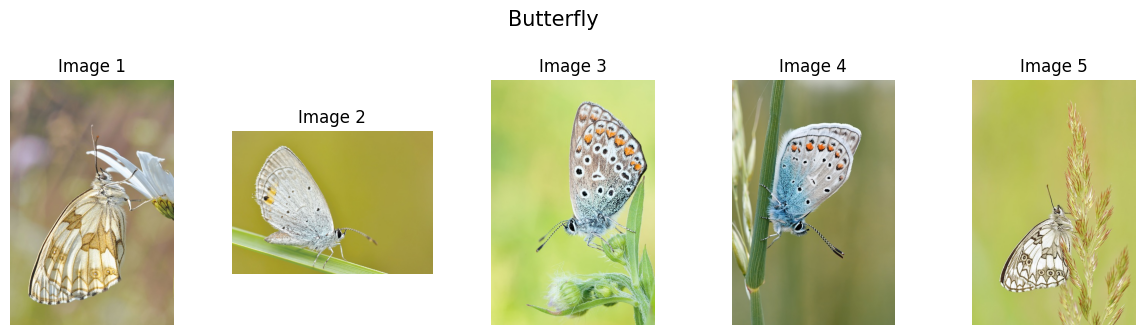

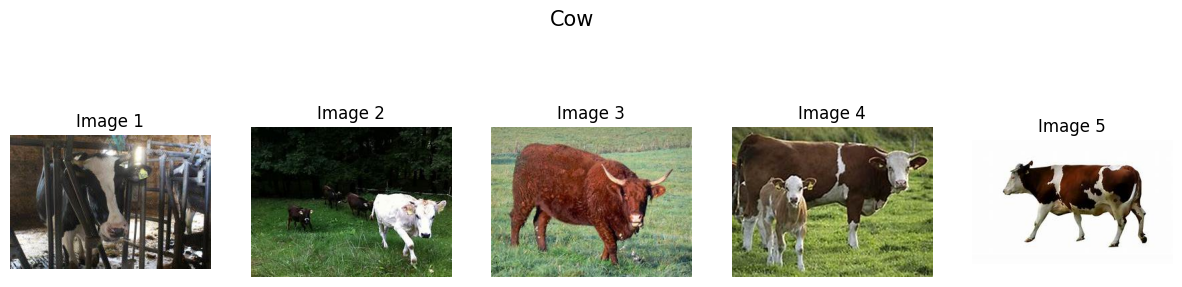

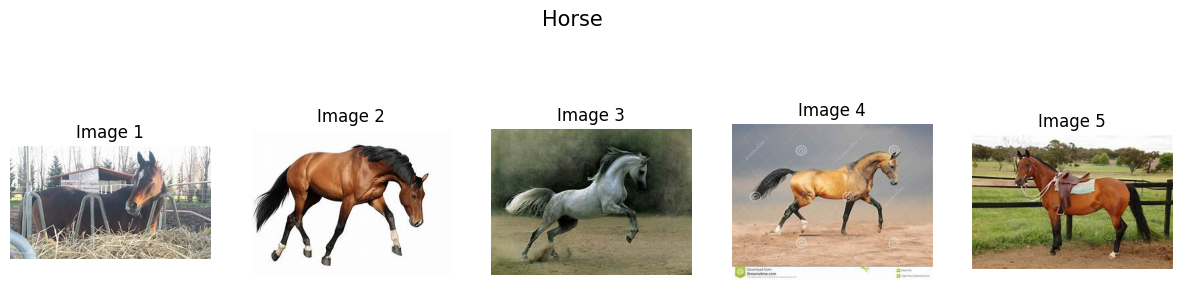

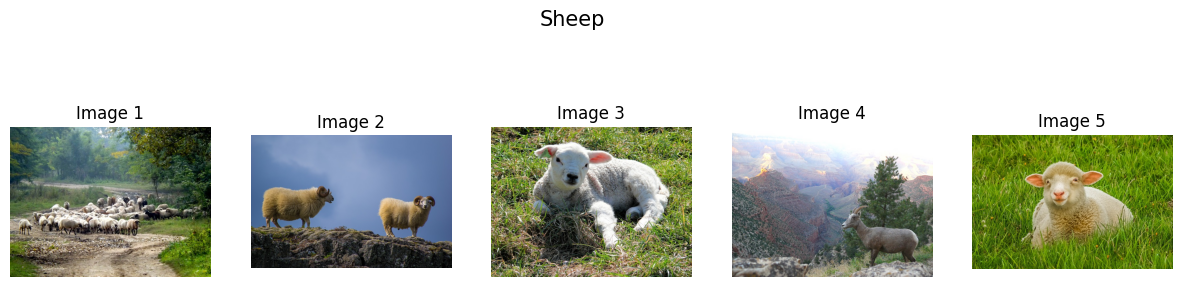

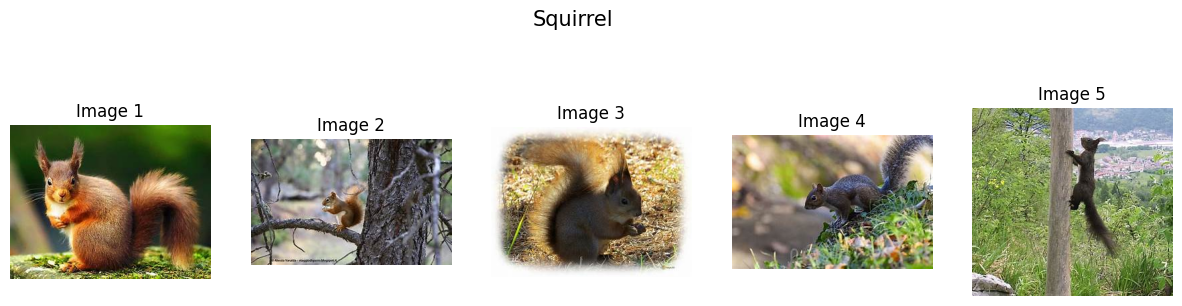

In [6]:
# Display the images
def display_image(folder_path, category):
    image_files = os.listdir(os.path.join(folder_path, category))

    # Take the first 5 images
    selected_images = image_files[:5]

    # Display the images in a horizontal 5x2 grid
    plt.figure(figsize=(15, 7))
    for i, image_name in enumerate(selected_images, 1):
        image_path = os.path.join(folder_path, category, image_name)
        image = Image.open(image_path)
        plt.subplot(2, 5, i)
        plt.imshow(image)
        plt.title(f"Image {i}")
        plt.axis("off")

    plt.suptitle(category.capitalize(), fontsize=15)
    plt.show()

for file in files:
    display_image(folder_path, file)

In [10]:
# Total Image
total_images = 0
for animal in files:
    images = len(os.listdir(f'{folder_path}/{animal}'))
    print(f'{animal} images: ', images)
    total_images += images
print("---------------------")
print (f'Total Images : {total_images}')

butterfly images:  2112
cow images:  1866
horse images:  2623
sheep images:  1820
squirrel images:  1862
---------------------
Total Images : 10283


In [11]:
# Train data image generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,  # Random horizontal flipping of images
    validation_split=0.2
)

# Validation data image generator
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [12]:
# Set up data generator for training
train_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Set up data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 8228 images belonging to 5 classes.
Found 2055 images belonging to 5 classes.


In [13]:
# Display the class indices
print("Class Indices:", train_generator.class_indices)

Class Indices: {'butterfly': 0, 'cow': 1, 'horse': 2, 'sheep': 3, 'squirrel': 4}


In [14]:
base_model = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='max'
)

94668760/94668760 [==============================] - 5s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [17]:
# Create a Sequential model
model = Sequential()
model.add(base_model)
model.add(Dense(5, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23575045 (89.93 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=0.0000015
)

In [21]:
# Callback
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.92
           and logs.get('val_accuracy') > 0.92):
            self.model.stop_training = True
            print("\nAccuracy is sufficient > 92%!")

callbacks = myCallback()

In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callbacks, reduce_lr]
)

Epoch 1/100
258/258 [==============================] - 186s 690ms/step - loss: 1.0170 - accuracy: 0.8777 - val_loss: 0.4713 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 2/100
258/258 [==============================] - 174s 677ms/step - loss: 0.5706 - accuracy: 0.9282 - val_loss: 0.8502 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 3/100
258/258 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.9398
Accuracy is sufficient > 92%!
258/258 [==============================] - 173s 670ms/step - loss: 0.4944 - accuracy: 0.9398 - val_loss: 0.5605 - val_accuracy: 0.9353 - lr: 0.0010


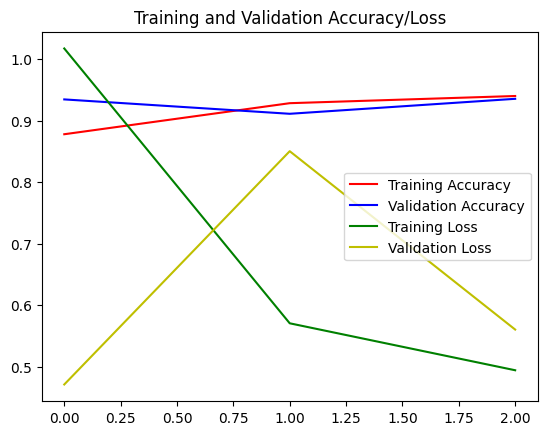

<Figure size 640x480 with 0 Axes>

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

# Plot training and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'y', label='Validation Loss')

plt.title('Training and Validation Accuracy/Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [36]:

true_labels = validation_generator.classes

num_samples = len(validation_generator.classes)

predictions = model.predict(validation_generator, steps=np.ceil(num_samples / validation_generator.batch_size), verbose=1)

predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_labels[:num_samples], predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_labels[:num_samples], predicted_labels, target_names=validation_generator.class_indices.keys()))


2055/2055 [==============================] - 25s 11ms/step
Confusion Matrix:
[[421   0   0   0   1]
 [  2 358   8   5   0]
 [  0  24 498   0   2]
 [  1  67   8 283   5]
 [  6   1   1   2 362]]

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.98      1.00      0.99       422
         cow       0.80      0.96      0.87       373
       horse       0.97      0.95      0.96       524
       sheep       0.98      0.78      0.87       364
    squirrel       0.98      0.97      0.98       372

    accuracy                           0.94      2055
   macro avg       0.94      0.93      0.93      2055
weighted avg       0.94      0.94      0.94      2055



In [37]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with tf.io.gfile.GFile('animals-6.tflite', 'wb') as f:
    f.write(tflite_model)

In [38]:
tf.saved_model.save(model,'content/')

Testing Model

In [33]:
filenames = validation_generator.filenames

In [34]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [39]:
val_df = pd.DataFrame()
val_df['filename'] = filenames

val_df['actual'] = true_labels

val_df['predicted'] = predicted_labels

val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])

val_df.loc[val_df['actual'] == val_df['predicted'], 'PredictionMatch'] = True
val_df.loc[val_df['actual'] != val_df['predicted'], 'PredictionMatch'] = False

val_df = val_df.sample(frac=1).reset_index(drop=True)

val_df.head(10)

filename     actual  predicted  \
0      horse/OIP-7KG9dIEhes15s5ZPlrWFFgHaE8.jpeg      horse        cow   
1  butterfly/OIP-4BhnWjuF4k_IMrKT6PKDtgHaHa.jpeg  butterfly  butterfly   
2   squirrel/OIP-42QFlOtVQeW3ectq52vungHaE8.jpeg   squirrel   squirrel   
3      horse/OIP-0b4F6_zQfANx6SOMUAlWwgHaFw.jpeg      horse      horse   
4      horse/OIP-6PzRk4rkE9pTBqmcX8aZVQHaEK.jpeg      horse      horse   
5      sheep/OIP-AjCni4USPSR0Xf-i1PKrUQHaFj.jpeg      sheep      sheep   
6  butterfly/OIP-40xupskAVNmz4Ql5_cIlbgAAAA.jpeg  butterfly  butterfly   
7      sheep/OIP-CrhY2XOzOodCJPBmZWa4nAHaFj.jpeg      sheep      sheep   
8      horse/OIP--PeOH-_0Qn0pSoANG_VfzQHaE-.jpeg      horse      horse   
9        cow/OIP-9Dxk2-FlgbeuFXxM2kxwqwHaE8.jpeg        cow        cow   

  PredictionMatch  
0           False  
1            True  
2            True  
3            True  
4            True  
5            True  
6            True  
7            True  
8            True  
9            True

In [44]:
# Function to read an image from the given path
def read_image(path):
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0

    for i in range(20):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = read_image(f"/content/drive/MyDrive/IDCamp2023/Pengembangan ML/Animal Classification/Animals/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

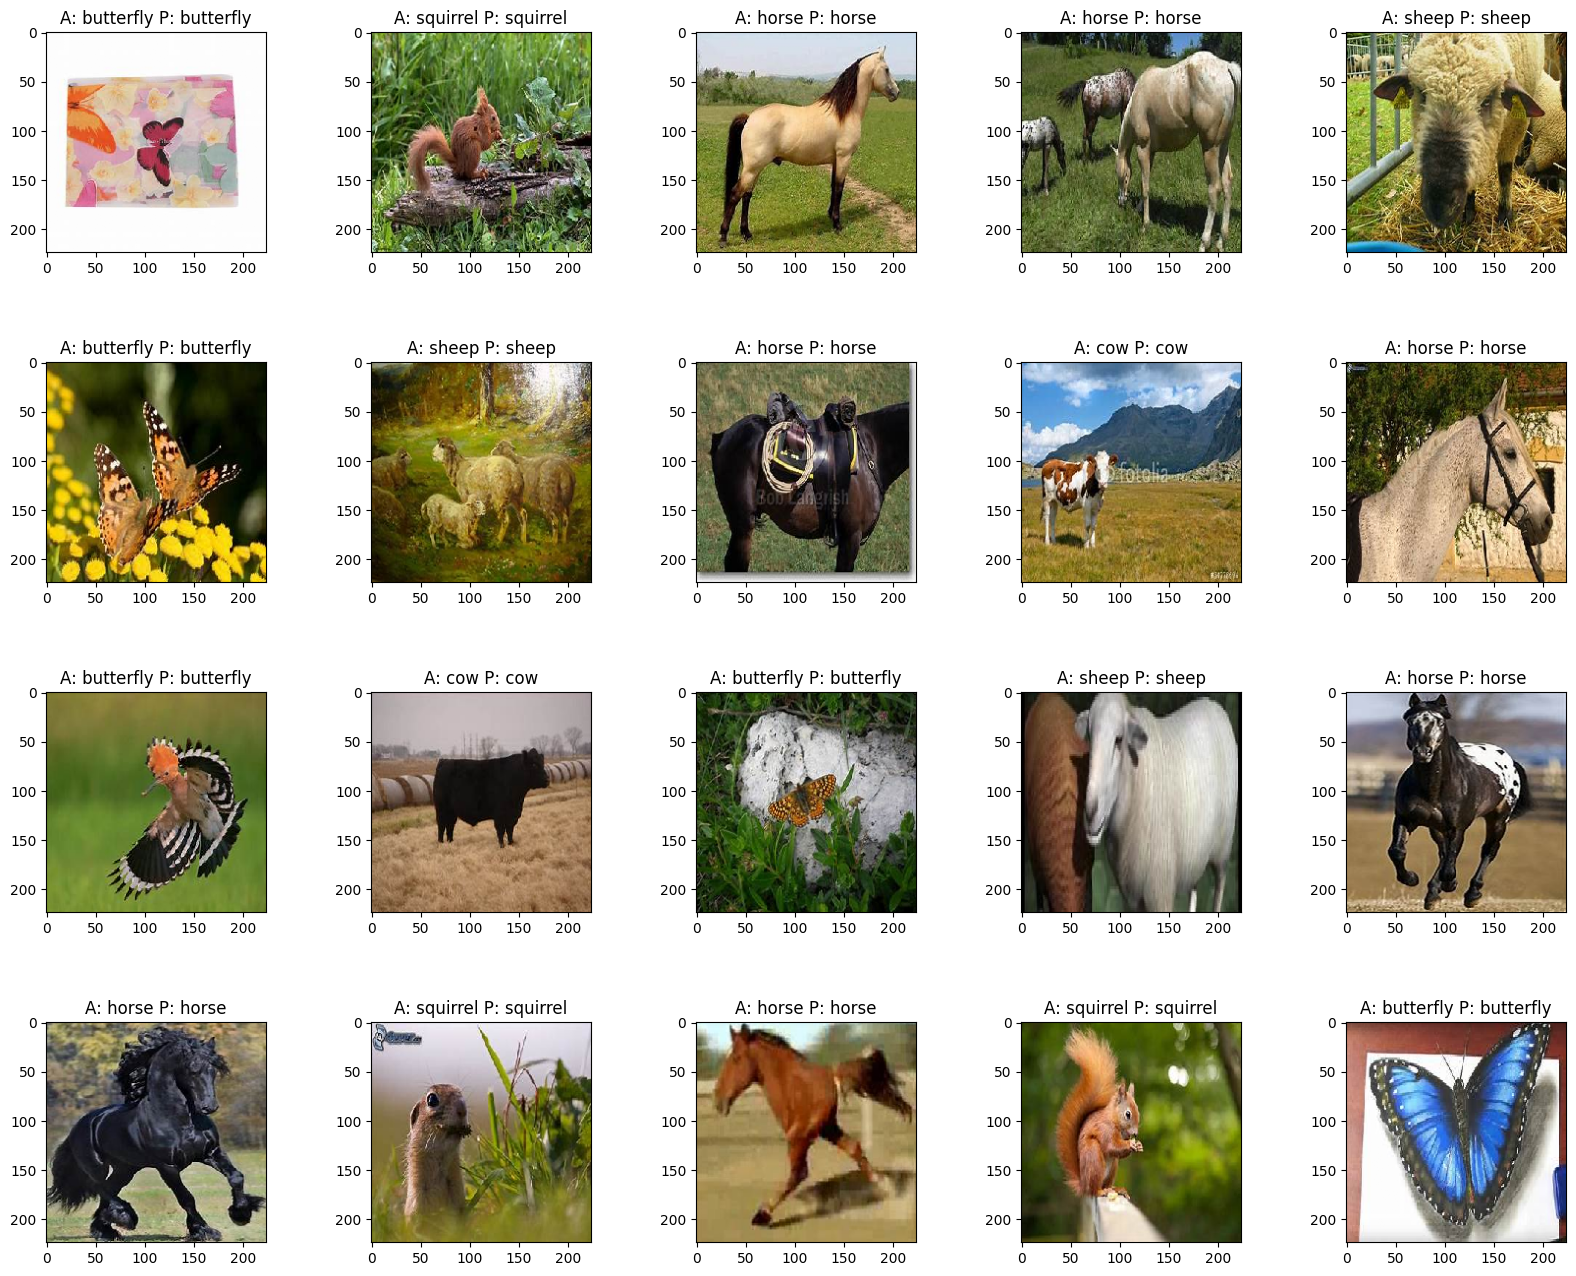

In [45]:
display_images(val_df[val_df['PredictionMatch']==True])

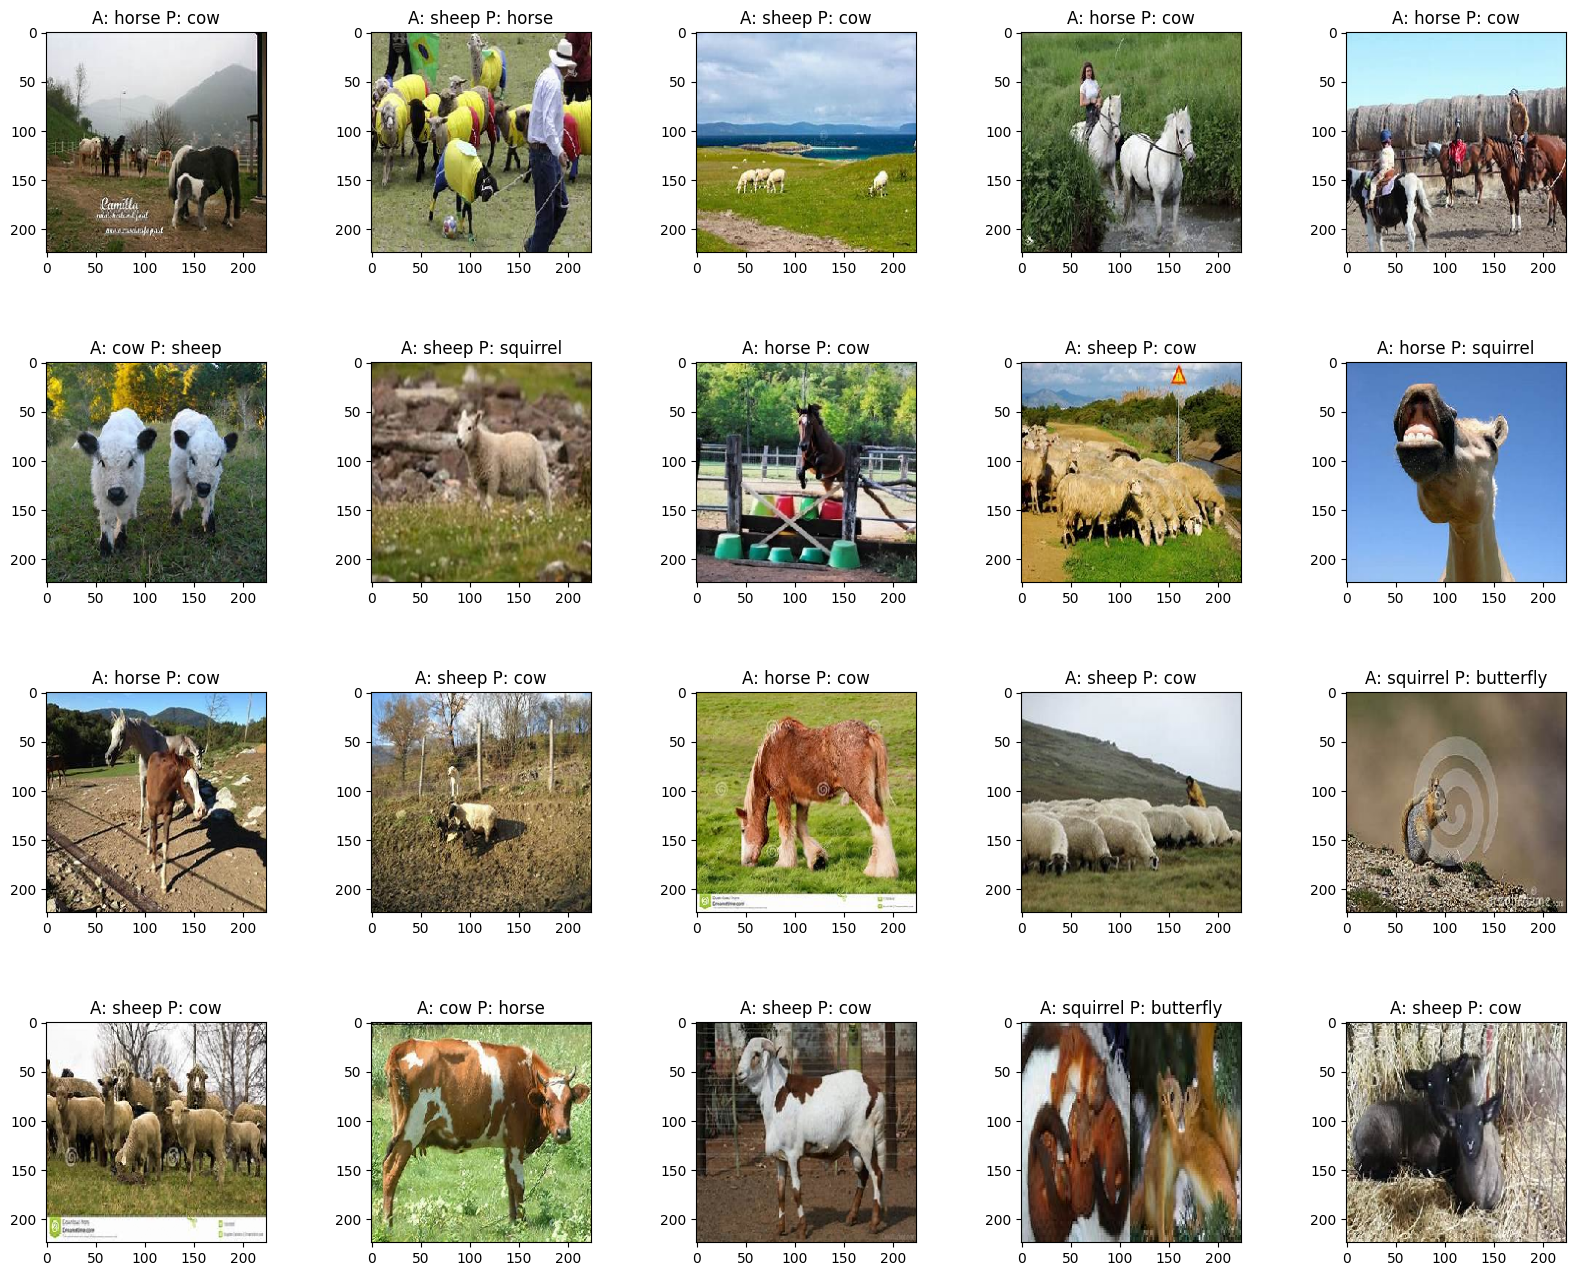

In [46]:
display_images(val_df[val_df['PredictionMatch']==False])